In [419]:
import numpy as np
import pyGMs as gm
import matplotlib.pyplot as plt
import time
import pyGMs.ising
import pickle
import numpy as np
from itertools import product
import pandas as pd
from math import log, sqrt
import os
import matplotlib.pyplot as plt

### Get Data

In [410]:
with open('user_dict.pkl', 'rb') as f:
    data = pickle.load(f)

print(type(data))
print(data)

<class 'dict'>
{1: array([ 5., nan, nan, ..., nan, nan, nan], shape=(3883,)), 2: array([nan, nan, nan, ..., nan, nan, nan], shape=(3883,)), 3: array([nan, nan, nan, ..., nan, nan, nan], shape=(3883,)), 4: array([nan, nan, nan, ..., nan, nan, nan], shape=(3883,)), 5: array([nan, nan, nan, ..., nan, nan, nan], shape=(3883,)), 6: array([ 4., nan, nan, ..., nan, nan, nan], shape=(3883,)), 7: array([nan, nan, nan, ..., nan, nan, nan], shape=(3883,)), 8: array([ 4., nan, nan, ..., nan, nan, nan], shape=(3883,)), 9: array([ 5., nan, nan, ..., nan, nan, nan], shape=(3883,)), 10: array([ 5.,  5., nan, ..., nan, nan, nan], shape=(3883,)), 11: array([nan, nan, nan, ..., nan, nan, nan], shape=(3883,)), 12: array([nan, nan, nan, ..., nan, nan, nan], shape=(3883,)), 13: array([nan,  3., nan, ..., nan, nan, nan], shape=(3883,)), 14: array([nan, nan, nan, ..., nan, nan, nan], shape=(3883,)), 15: array([nan, nan, nan, ..., nan, nan, nan], shape=(3883,)), 16: array([nan, nan, nan, ..., nan, nan, nan], s

In [429]:
user_ids = sorted(data.keys())
num_users = len(user_ids)
num_movies = len(data[user_ids[0]])

X = np.full((num_users, num_movies), np.nan)

for i, user_id in enumerate(user_ids):
    X[i] = data[user_id]

print("Matrix shape:", X.shape)

Matrix shape: (6040, 3883)


In [412]:
Xte = X[:1000]
Xtr = X[1000:]
print("X_te shape:", Xte.shape)
print("X_tr shape:", Xtr.shape)

X_te shape: (1000, 3883)
X_tr shape: (5040, 3883)


In [413]:
Xtr_missing = np.where(np.isnan(Xtr), -1, Xtr).astype(int)
Xte_missing = np.where(np.isnan(Xte), -1, Xte).astype(int)

In [414]:
Xtr = (Xtr >= 4).astype(int)
Xte = (Xte >= 4).astype(int)

### Model

In [ ]:
# Experiment setup
input_sizes = [50, 100, 500, 1000]
all_results = []

for m in input_sizes:
    
    Xtr_subset = Xtr[:m]
    m_subset, n_subset = Xtr_subset.shape
    
    epsilon = sqrt(log(n_subset) / m_subset)
    learning_rates = {
        'fast': 1 - 0.5 * epsilon,
        'default': 1 - 1.0 * epsilon,
        'slow': 1 - 1.5 * epsilon
    }


    param_grid = {
    'C': [1, 2, 5, 10],
    'threshold': [5e-2],
    'lr_type': ['slow']
    }

    for C, threshold, lr_type in product(param_grid['C'], param_grid['threshold'], param_grid['lr_type']):
        lr = learning_rates[lr_type]

        # Training
        train_start = time.time()
        model = gm.ising.fit_mweight(
            Xtr_subset,
            C=C,
            threshold=threshold,
            learning_rate=lr
        )
        train_time = time.time() - train_start

        # Metrics
        pll_train = model.pseudolikelihood(Xtr_subset).mean()
        pll_test = model.pseudolikelihood(Xte).mean()
        print(f"Train Pseudo-log-likelihood: {pll_train:.4f}")
        print(f"Test Pseudo-log-likelihood: {pll_test:.4f}")

        result = {
            'input_size': m,
            'C': C,
            'threshold': threshold,
            'lr_type': lr_type,
            'lr_value': lr,
            'train_pseudolikelihood': pll_train,
            'test_pseudolikelihood': pll_test,
            'training_time_seconds': train_time
        }

        output_path = 'results/ising_model_size_experiment_latest.csv'
        os.makedirs('results', exist_ok=True)

        write_header = not os.path.exists(output_path)
        results_df = pd.DataFrame([result])
        results_df.to_csv(output_path, mode='a', header=write_header, index=False)

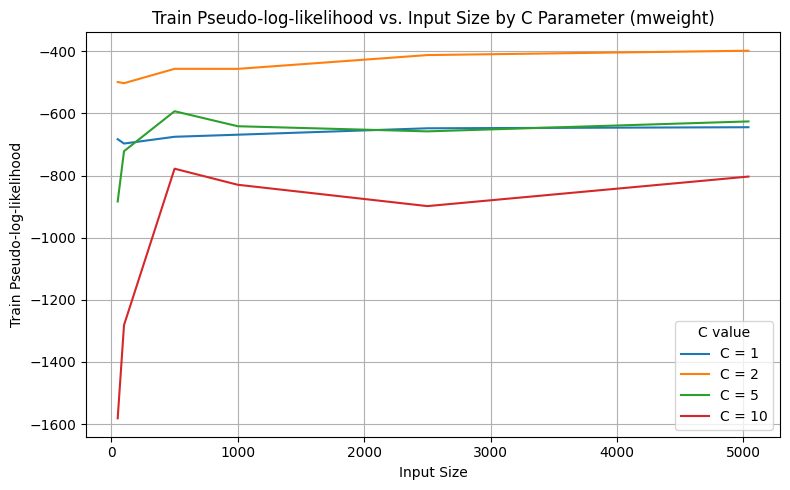

In [ ]:
df = pd.read_csv('results/ising_model_size_experiment_latest _FULL.csv')

pivot_df = df.pivot(index='input_size', columns='C', values='train_pseudolikelihood')

plt.figure(figsize=(8, 5))
for c_val in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[c_val], label=f'C = {c_val}')

plt.xlabel('Input Size')
plt.ylabel('Train Pseudo-log-likelihood')
plt.title('Train Pseudo-log-likelihood vs. Input Size by C Parameter (mweight)')
plt.legend(title='C value')
plt.grid(True)
plt.show()

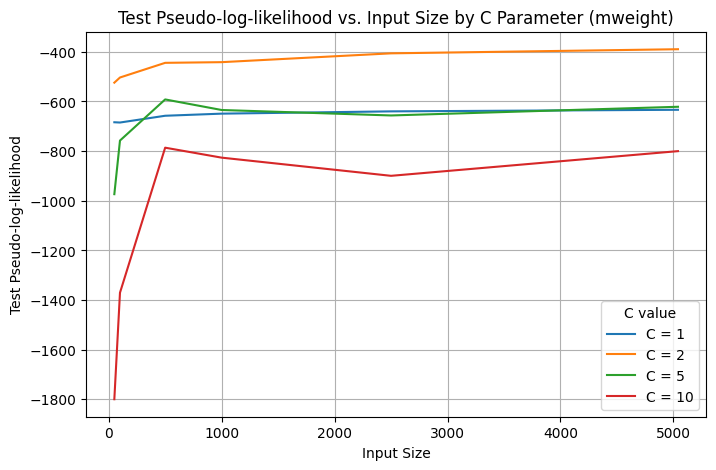

In [428]:
df = pd.read_csv('results/ising_model_size_experiment_latest _FULL.csv')

pivot_df = df.pivot(index='input_size', columns='C', values='test_pseudolikelihood')

plt.figure(figsize=(8, 5))
for c_val in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[c_val], label=f'C = {c_val}')

plt.xlabel('Input Size')
plt.ylabel('Test Pseudo-log-likelihood')
plt.title('Test Pseudo-log-likelihood vs. Input Size by C Parameter (mweight)')
plt.legend(title='C value')
plt.grid(True)
plt.show()

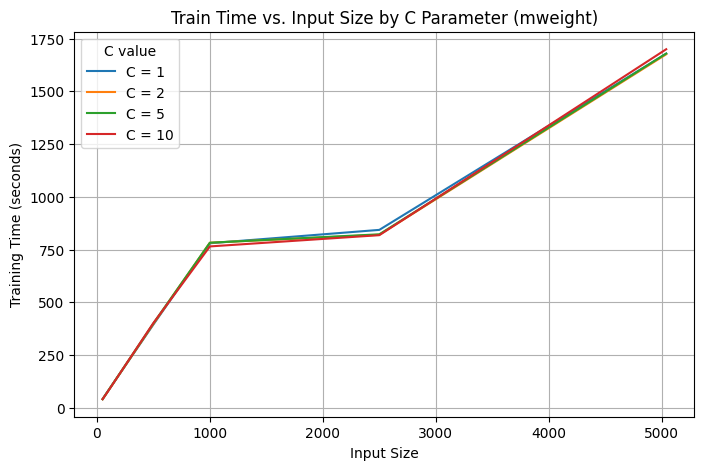

In [427]:
df = pd.read_csv('results/ising_model_size_experiment_latest _FULL.csv')

pivot_df = df.pivot(index='input_size', columns='C', values='training_time_seconds')

plt.figure(figsize=(8, 5))
for c_val in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[c_val], label=f'C = {c_val}')

plt.xlabel('Input Size')
plt.ylabel('Training Time (seconds)')
plt.title('Train Time vs. Input Size by C Parameter (mweight)')
plt.legend(title='C value')
plt.grid(True)
plt.show()